# Data Oriented Programming Paradigms - Exercise 3
<h3> Preprocessing "cwurData.csv" </h3>

In [81]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from fancyimpute import KNN
import plotly.plotly as py
import lightgbm as lgb

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb

#Using TensorFlow backend.

In [2]:
# Read CSV file-
cwur_data = pd.read_csv("cwurData.csv")

In [3]:
# Get shape/dimension of data-
cwur_data.shape

(2200, 14)

In [4]:
# Get information about dataset-
cwur_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 14 columns):
world_rank              2200 non-null int64
institution             2200 non-null object
country                 2200 non-null object
national_rank           2200 non-null int64
quality_of_education    2200 non-null int64
alumni_employment       2200 non-null int64
quality_of_faculty      2200 non-null int64
publications            2200 non-null int64
influence               2200 non-null int64
citations               2200 non-null int64
broad_impact            2000 non-null float64
patents                 2200 non-null int64
score                   2200 non-null float64
year                    2200 non-null int64
dtypes: float64(2), int64(10), object(2)
memory usage: 240.7+ KB


In [5]:
# Check for missing value(s)-
cwur_data.isnull().values.any()

True

In [6]:
# Get column/attribute names containing NAs-
cwur_data.isnull().sum()

world_rank                0
institution               0
country                   0
national_rank             0
quality_of_education      0
alumni_employment         0
quality_of_faculty        0
publications              0
influence                 0
citations                 0
broad_impact            200
patents                   0
score                     0
year                      0
dtype: int64

In [7]:
# Get number of unique values for 'institution' column-
len(cwur_data['institution'].unique().tolist())

1024

In [8]:
# Get number of unique values for 'country' column-
len(cwur_data['country'].unique().tolist())

59

In [9]:
# Do label encoding for the 2 columns. Transform Categories into Integers-
labelencoder = preprocessing.LabelEncoder()
labelencoder2 = preprocessing.LabelEncoder()

labelencoder.fit(cwur_data['institution'])
labelencoder2.fit(cwur_data['country'])

LabelEncoder()

In [10]:
# Transform categories into integers- apply fitted encoder to pandas column-
encoded_institution = labelencoder.transform(cwur_data['institution'])
encoded_country = labelencoder2.transform(cwur_data['country'])

In [11]:
# Add new columns to DataFrame-
cwur_data['encoded_institution'] = encoded_institution
cwur_data['encoded_country'] = encoded_country

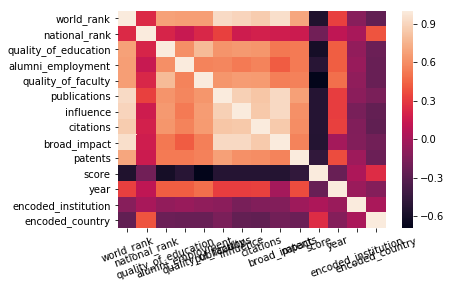

In [12]:
# Visualizations:

# Columns to use for visualization-
cols_to_use = []
cols_to_use = cwur_data.columns.tolist()

# Remove the following 2 columns from list-                            
cols_to_use.remove('country')
cols_to_use.remove('institution')

# Compute correlation for columns in 'cols_to_use'-
corr_mat = cwur_data.loc[:, cols_to_use].corr()

# Create a correlation graph-
sns.heatmap(corr_mat)
plt.xticks(rotation = 20)

plt.rcParams['figure.figsize'] = [25, 10]  # creates a figure with 25 (width) x 10 (height) inches

plt.show()

# We can use the correlation graph for further exploratory analysis!

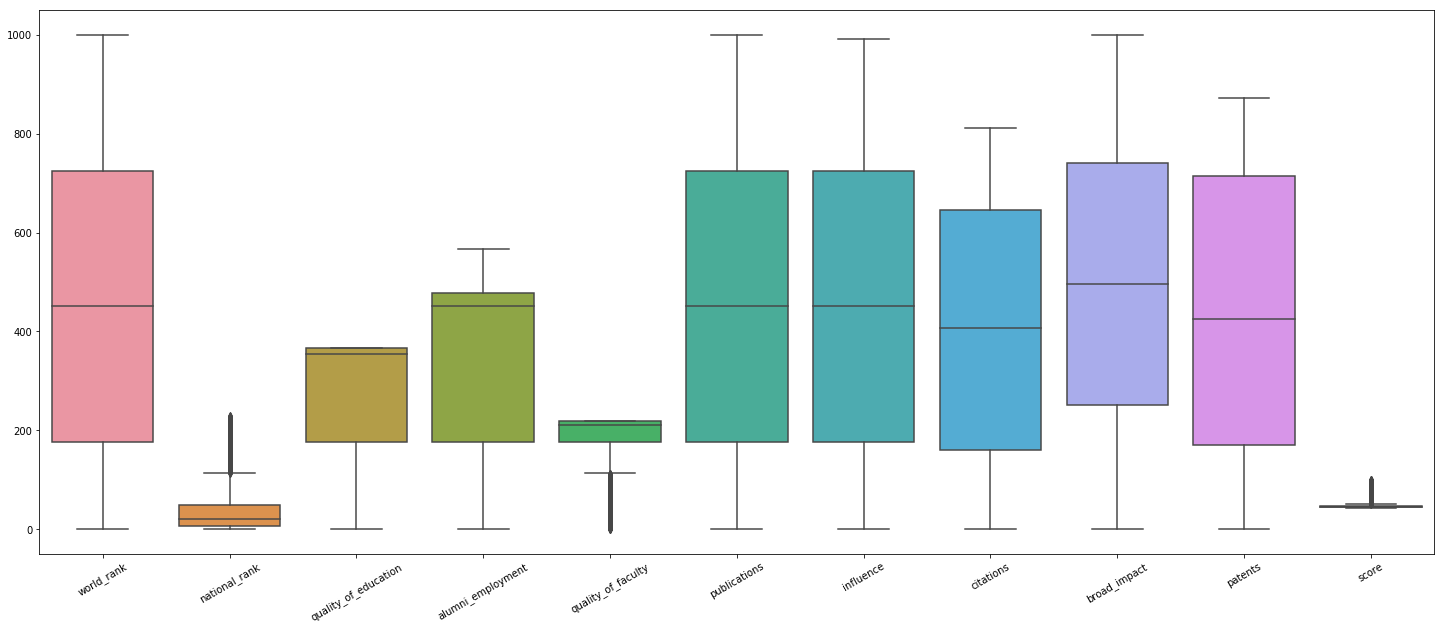

In [13]:
# Boxplots-

# Create a list variable to store all attribute/column names for which
# boxplots have to be drawn-
cols_boxplot = cols_to_use.copy()

# Remove the following columns/attributes-
cols_boxplot.remove('year')
cols_boxplot.remove('encoded_country')
cols_boxplot.remove('encoded_institution')



# This will make boxplots for each numeric column of your dataframe-
# sns.boxplot(data = cwur_data)
sns.boxplot(data = cwur_data.loc[:, cols_boxplot])

# Rotate text on x-axis by 30 degrees-
plt.xticks(rotation = 30)

plt.show()

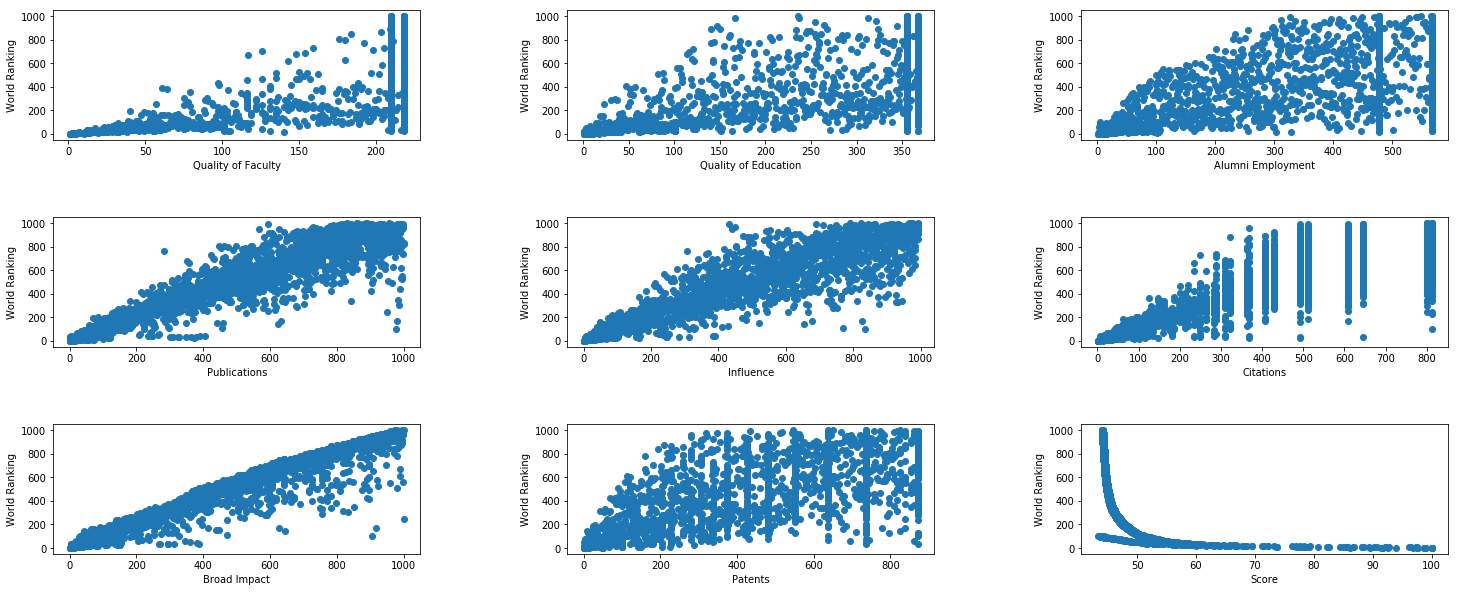

In [14]:
# Draw multiple plots together-
# Scatter plot of different attributes with 'world_rank' attribute to see correlation


fig, ax = plt.subplots(3, 3)

# Adjust spacing between plots-
fig.subplots_adjust(hspace = 0.6, wspace = 0.4)

ax[0, 0].scatter(cwur_data["quality_of_faculty"], cwur_data["world_rank"])
ax[0, 0].set_xlabel("Quality of Faculty")
ax[0, 0].set_ylabel("World Ranking")

ax[0, 1].scatter(cwur_data["quality_of_education"], cwur_data["world_rank"])
ax[0, 1].set_xlabel("Quality of Education")
ax[0, 1].set_ylabel("World Ranking")

ax[0, 2].scatter(cwur_data["alumni_employment"], cwur_data["world_rank"])
ax[0, 2].set_xlabel("Alumni Employment")
ax[0, 2].set_ylabel("World Ranking")

ax[1, 0].scatter(cwur_data["publications"], cwur_data["world_rank"])
ax[1, 0].set_xlabel("Publications")
ax[1, 0].set_ylabel("World Ranking")

ax[1, 1].scatter(cwur_data["influence"], cwur_data["world_rank"])
ax[1, 1].set_xlabel("Influence")
ax[1, 1].set_ylabel("World Ranking")

ax[1, 2].scatter(cwur_data["citations"], cwur_data["world_rank"])
ax[1, 2].set_xlabel("Citations")
ax[1, 2].set_ylabel("World Ranking")

ax[2, 0].scatter(cwur_data["broad_impact"], cwur_data["world_rank"])
ax[2, 0].set_xlabel("Broad Impact")
ax[2, 0].set_ylabel("World Ranking")

ax[2, 1].scatter(cwur_data["patents"], cwur_data["world_rank"])
ax[2, 1].set_xlabel("Patents")
ax[2, 1].set_ylabel("World Ranking")

ax[2, 2].scatter(cwur_data["score"], cwur_data["world_rank"])
ax[2, 2].set_xlabel("Score")
ax[2, 2].set_ylabel("World Ranking")

plt.show()


# Further Data Visualization

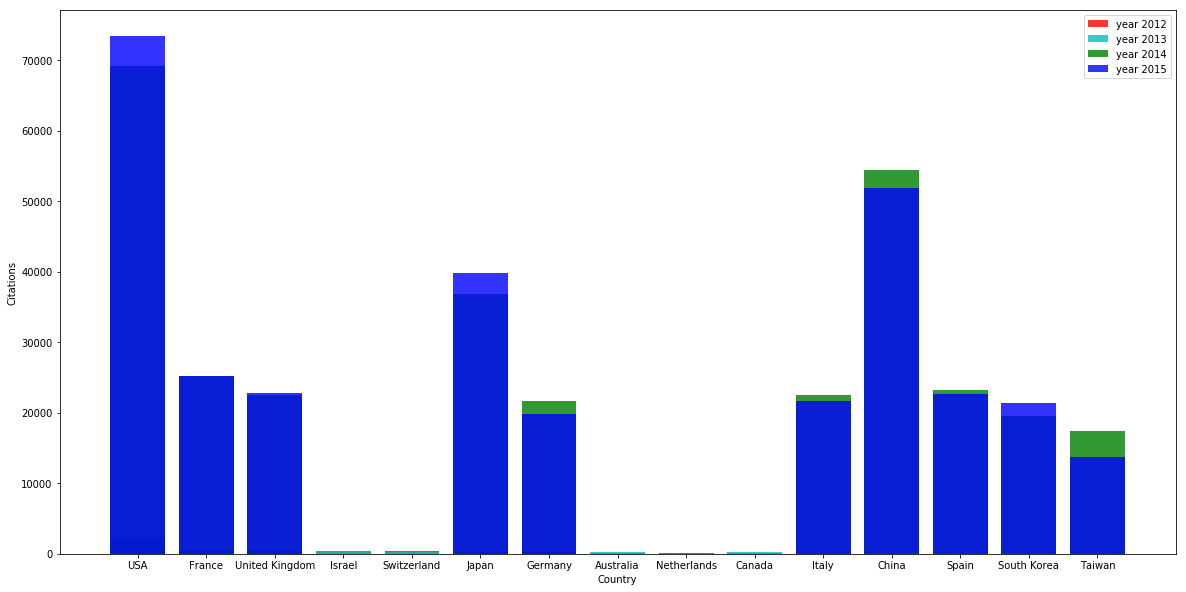

In [15]:
#it would be interesting to see, which countries were cited the most per year:

citation_data = pd.DataFrame(cwur_data.groupby(['country', 'year'])['citations'].agg('sum')).reset_index().sort_values(by=['year', 'citations'],ascending=False)
citation_data = citation_data.set_index(['country']).groupby('year')['citations'].nlargest(10).reset_index() 
citation_data

cit_2012 = citation_data.loc[citation_data['year'] == 2012].loc[:,'citations'].values
cit_2013 = citation_data.loc[citation_data['year'] == 2013].loc[:,'citations'].values
cit_2014 = citation_data.loc[citation_data['year'] == 2014].loc[:,'citations'].values
cit_2015 = citation_data.loc[citation_data['year'] == 2015].loc[:,'citations'].values

country_2012 = citation_data.loc[citation_data['year'] == 2012].loc[:,'country'].values
country_2013 = citation_data.loc[citation_data['year'] == 2013].loc[:,'country'].values
country_2014 = citation_data.loc[citation_data['year'] == 2014].loc[:,'country'].values
country_2015 = citation_data.loc[citation_data['year'] == 2015].loc[:,'country'].values

plt.figure(figsize=(20,10))
plt.bar(country_2012, cit_2012, align='center', alpha=0.8, color='r', label="year 2012")
plt.bar(country_2013, cit_2013, align='center', alpha=0.8, color='c', label="year 2013")
plt.bar(country_2014, cit_2014, align='center', alpha=0.8, color='g', label="year 2014")
plt.bar(country_2015, cit_2015, align='center', alpha=0.8, color='b', label="year 2015")
plt.legend(loc = 'upper right')
plt.ylabel("Citations")
plt.xlabel("Country")


plt.show()

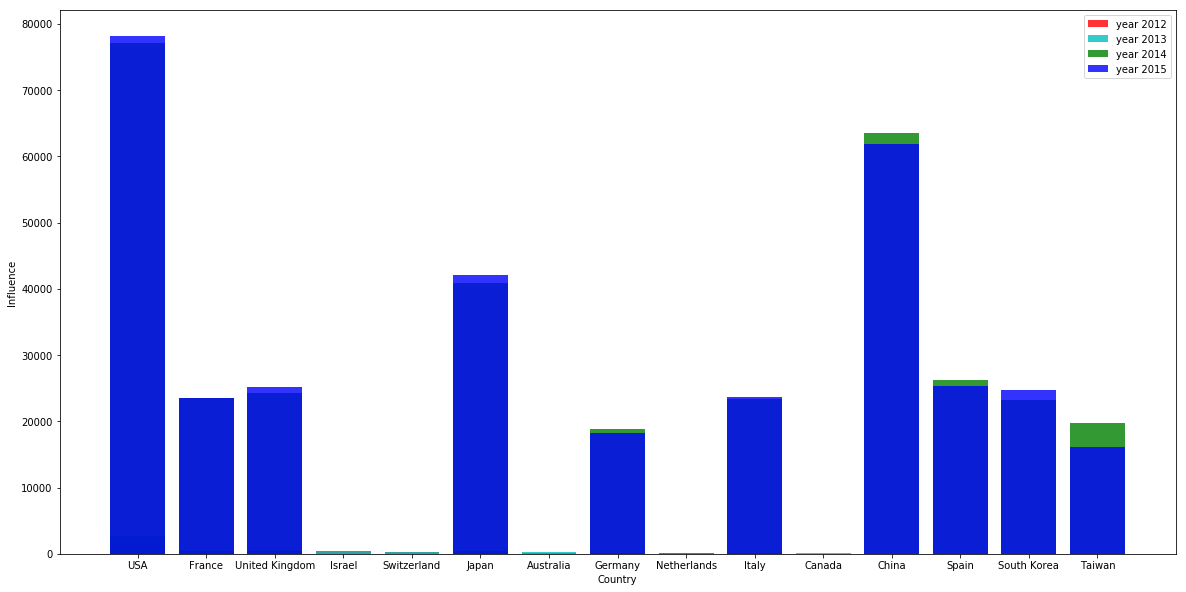

In [16]:
# similarly as above just instead of citations we are interestd in the influence of a given
# country

influence_data = pd.DataFrame(cwur_data.groupby(['country', 'year'])['influence'].agg('sum')).reset_index().sort_values(by=['year', 'influence'],ascending=False)
influence_data = influence_data.set_index(['country']).groupby('year')['influence'].nlargest(10).reset_index() 

inf_2012 = influence_data.loc[influence_data['year'] == 2012].loc[:,'influence'].values
inf_2013 = influence_data.loc[influence_data['year'] == 2013].loc[:,'influence'].values
inf_2014 = influence_data.loc[influence_data['year'] == 2014].loc[:,'influence'].values
inf_2015 = influence_data.loc[influence_data['year'] == 2015].loc[:,'influence'].values

country_2012 = influence_data.loc[influence_data['year'] == 2012].loc[:,'country'].values
country_2013 = influence_data.loc[influence_data['year'] == 2013].loc[:,'country'].values
country_2014 = influence_data.loc[influence_data['year'] == 2014].loc[:,'country'].values
country_2015 = influence_data.loc[influence_data['year'] == 2015].loc[:,'country'].values

plt.figure(figsize=(20,10))
plt.bar(country_2012, inf_2012, align='center', alpha=0.8, color='r', label="year 2012")
plt.bar(country_2013, inf_2013, align='center', alpha=0.8, color='c', label="year 2013")
plt.bar(country_2014, inf_2014, align='center', alpha=0.8, color='g', label="year 2014")
plt.bar(country_2015, inf_2015, align='center', alpha=0.8, color='b', label="year 2015")
plt.legend(loc = 'upper right')
plt.ylabel("Influence")
plt.xlabel("Country")

plt.show()

# this plot is very similar to the above one (we are not surprised,
# as influence and citations should be correlated).


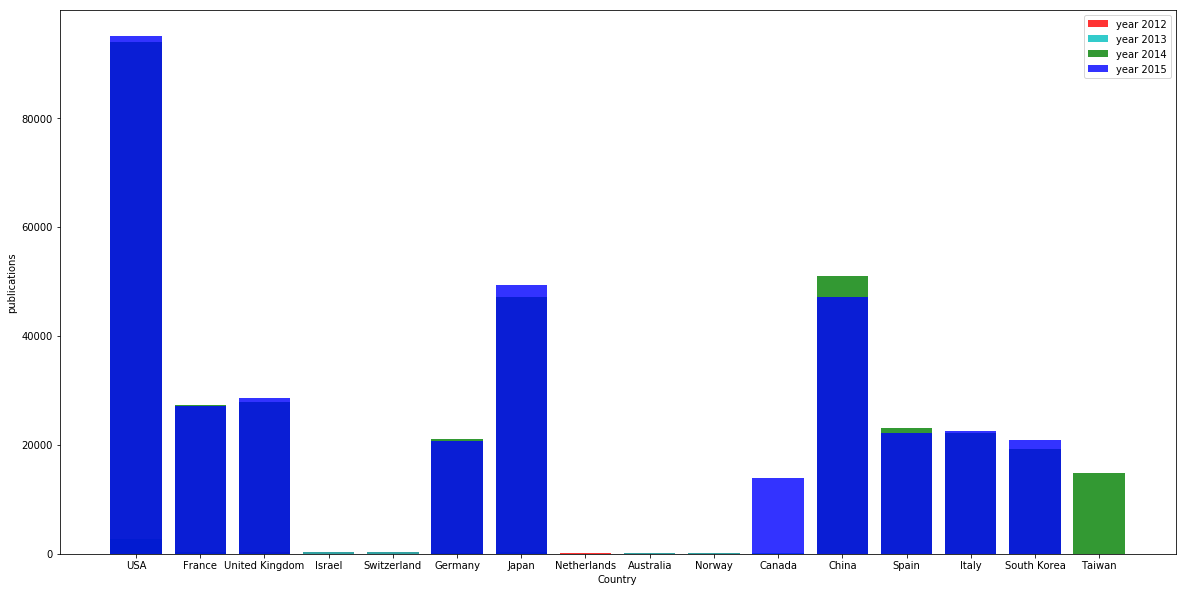

In [17]:
#let's see what happens with the publications:

publ_data = pd.DataFrame(cwur_data.groupby(['country', 'year'])['publications'].agg('sum')).reset_index().sort_values(by=['year', 'publications'],ascending=False)
publ_data = publ_data.set_index(['country']).groupby('year')['publications'].nlargest(10).reset_index() 

pub_2012 = publ_data.loc[publ_data['year'] == 2012].loc[:,'publications'].values
pub_2013 = publ_data.loc[publ_data['year'] == 2013].loc[:,'publications'].values
pub_2014 = publ_data.loc[publ_data['year'] == 2014].loc[:,'publications'].values
pub_2015 = publ_data.loc[publ_data['year'] == 2015].loc[:,'publications'].values

country_2012 = publ_data.loc[publ_data['year'] == 2012].loc[:,'country'].values
country_2013 = publ_data.loc[publ_data['year'] == 2013].loc[:,'country'].values
country_2014 = publ_data.loc[publ_data['year'] == 2014].loc[:,'country'].values
country_2015 = publ_data.loc[publ_data['year'] == 2015].loc[:,'country'].values

plt.figure(figsize=(20,10))
plt.bar(country_2012, pub_2012, align='center', alpha=0.8, color='r', label="year 2012")
plt.bar(country_2013, pub_2013, align='center', alpha=0.8, color='c', label="year 2013")
plt.bar(country_2014, pub_2014, align='center', alpha=0.8, color='g', label="year 2014")
plt.bar(country_2015, pub_2015, align='center', alpha=0.8, color='b', label="year 2015")
plt.legend(loc = 'upper right')
plt.ylabel("publications")
plt.xlabel("Country")

plt.show()

# Taiwan seemed to be very active in 2014

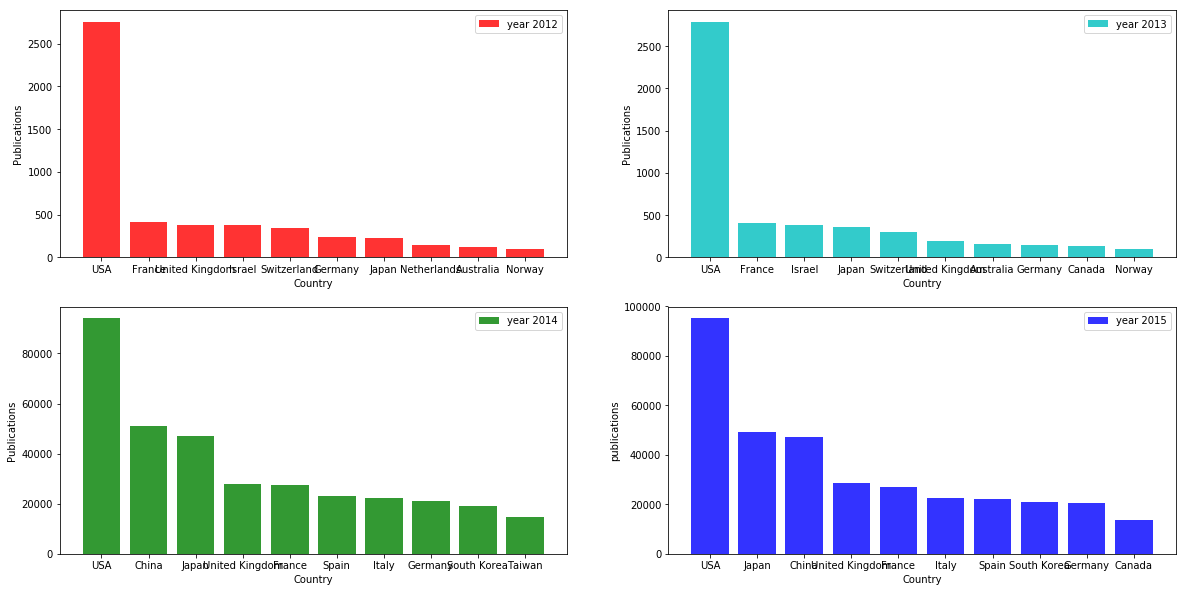

In [18]:
# the scale of the "publications" variable is not consistent, it would be
# beneficial to see whether the ratios between tha number of publications per cpuntry
# remains similar among the years, this could validate the "trustworthyness" of the data.

publ_data_orig = pd.DataFrame(cwur_data.groupby(['country', 'year'])['publications'].agg('sum')).reset_index().sort_values(by=['year', 'publications'],ascending=False)
publ_data = publ_data_orig.set_index(['country']).groupby('year')['publications'].nlargest(10).reset_index() 

pub_2012 = publ_data.loc[publ_data['year'] == 2012].loc[:,'publications'].values
pub_2013 = publ_data.loc[publ_data['year'] == 2013].loc[:,'publications'].values
pub_2014 = publ_data.loc[publ_data['year'] == 2014].loc[:,'publications'].values
pub_2015 = publ_data.loc[publ_data['year'] == 2015].loc[:,'publications'].values

country_2012 = publ_data.loc[publ_data['year'] == 2012].loc[:,'country'].values
country_2013 = publ_data.loc[publ_data['year'] == 2013].loc[:,'country'].values
country_2014 = publ_data.loc[publ_data['year'] == 2014].loc[:,'country'].values
country_2015 = publ_data.loc[publ_data['year'] == 2015].loc[:,'country'].values


fig, axes = plt.subplots(2, 2,figsize=(20,10))

axes[0, 0].bar(country_2012, pub_2012, align='center', alpha=0.8, color='r', label="year 2012")
axes[0, 0].set_xlabel("Country")
axes[0, 0].set_ylabel("Publications")
axes[0, 0].legend(loc = 'upper right')

axes[0, 1].bar(country_2013, pub_2013, align='center', alpha=0.8, color='c', label="year 2013")
axes[0, 1].set_xlabel("Country")
axes[0, 1].set_ylabel("Publications")
axes[0, 1].legend(loc = 'upper right')

axes[1, 0].bar(country_2014, pub_2014, align='center', alpha=0.8, color='g', label="year 2014")
axes[1, 0].set_xlabel("Country")
axes[1, 0].set_ylabel("Publications")
axes[1, 0].legend(loc = 'upper right')

axes[1, 1].bar(country_2015, pub_2015, align='center', alpha=0.8, color='b', label="year 2015")
plt.ylabel("publications")
plt.xlabel("Country")
plt.legend(loc = 'upper right')

plt.show()

In [19]:
#World heat map of publications to see whether there are clusters of very active countries:
#(if the plot is not showing or throws an error, there is a saved .png in the repo)
#please dont steal my plotly identity! :) 

#Let's plot only the nr of publications for the year 2015:

#first we have to import the codes for the countries:

import plotly
plotly.tools.set_credentials_file(username='Acornis1', api_key='l0bclp6NUdGGykTRnzqL')

codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
codes.rename(columns={'COUNTRY':'country'}, inplace = True)

world_data = publ_data_orig
world_data = world_data.loc[world_data['year'] == 2015]

world_data.replace("USA", "United States", inplace = True) #this step is neccesary for a sucessful merge

#now lets merge the codes with our dataset:

result = pd.merge(world_data, codes,  on = 'country')
world_data = result[['country','CODE','year','publications']]

data = [ dict(
        type = 'choropleth',
        locations = world_data['CODE'],
        z = world_data['publications'],
        text = world_data['country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '$',
            title = 'Publications'),
      ) ]

layout = dict(
    title = 'Number of publications of Countries in 2015',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )




c:\users\goso\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3798: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [20]:
# Dropping rows so only the top 100 universities are present
neshtositam = cwur_data.drop(cwur_data[cwur_data.world_rank > 100].index)

In [21]:
# Dropping column broad_impact because it has many missing values and is also kind of useless
neshtositam.drop(["broad_impact"], axis=1, inplace=True)

In [22]:
# Check for null values-
neshtositam.isnull().values.any()

False

In [23]:
# Further check for null values-
neshtositam.isnull().sum().sum()

0

In [24]:
neshtositam.shape

(400, 15)

In [25]:
# Get column names-
print("\nColumn names of 'neshtositam' are:\n{0}\n\n".format(neshtositam.columns.tolist()))


Column names of 'neshtositam' are:
['world_rank', 'institution', 'country', 'national_rank', 'quality_of_education', 'alumni_employment', 'quality_of_faculty', 'publications', 'influence', 'citations', 'patents', 'score', 'year', 'encoded_institution', 'encoded_country']




In [26]:
# Write 'neshtositam' as CSV for further processing-
# neshtositam.to_csv("cwurData-Preprocessed_and_Normalized.csv", index=False)

In [27]:
# This will show the dataframe only with the numerical values
columns = neshtositam.columns.tolist()
columns = columns[3:12]
bezimenna = neshtositam[columns]
bezimenna

,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,patents,score
0,1,7,9,1,1,1,1,5,100.00
1,2,9,17,3,12,4,4,1,91.67
2,3,17,11,5,4,2,2,15,89.50
3,1,10,24,4,16,16,11,50,86.17
4,4,2,29,7,37,22,22,18,85.21
5,5,8,14,2,53,33,26,101,82.50
6,2,13,28,9,15,13,19,26,82.34
7,6,14,31,12,14,6,15,66,79.14
8,7,23,21,10,13,12,14,5,78.86
9,8,16,52,6,6,5,3,16,78.55


In [28]:
# Calculates z-scores in order to witness any outliers
z = np.abs(stats.zscore(bezimenna))
for i in range(0, len(z)):
        for j in range(0, len(z[i])):
            if z[i][j] > 4:
                print(bezimenna.index.get_values()[i])
                print(z[i][j])

221
5.678227080904503
234
4.515861074278206
234
5.678227080904503
234
5.172813353322
236
4.286437390772823
239
4.95941352905528
239
5.384816056289386
247
5.172813353322
264
4.366309741492645
272
5.172813353322
299
4.165411104047787
299
4.366309741492645
1222
4.005424768621917
1228
4.668810196615128
1233
4.005424768621917
1235
4.199283463832276
1236
4.775874582250974
1236
7.712354692640129
1236
6.253528193173334
1237
5.188837212560663
1237
5.469496955750608
1237
4.005424768621917
1256
4.834081836353671
1258
6.172877831990399
1270
5.2212035700317605
1297
4.402517622539209


In [29]:
#The following code checks if there are universities with the same name, but with different countries. It prints them, if they exist. They do not.
neshtositam = neshtositam.reset_index()
listche = neshtositam['institution'].unique().tolist()
for i in range(len(listche)):
    current = listche[i]
    country = ""
    for j in range(len(neshtositam)):        
        if neshtositam['institution'].loc[j] == listche[i]:
            if country == "":
                country = neshtositam['country'].loc[j]
            if country != neshtositam['country'].loc[j]:
                print(current)
                print(country)

In [30]:
# This fixes index problems from previous code snippet
normalizedData = neshtositam
normalizedData.drop(["index"], axis=1, inplace=True)

In [31]:
# Scaling the data
normalizedData['quality_of_education'] = [round(100-(100*(number - neshtositam['quality_of_education'].min())/(neshtositam['quality_of_education'].max() - neshtositam['quality_of_education'].min())),2) 
                         for number in neshtositam['quality_of_education']]

normalizedData['alumni_employment'] = [round(100-(100*(number - neshtositam['alumni_employment'].min())/(neshtositam['alumni_employment'].max() - neshtositam['alumni_employment'].min())),2) 
                         for number in neshtositam['alumni_employment']]

normalizedData['quality_of_faculty'] = [round(100 - (100*(number - neshtositam['quality_of_faculty'].min())/(neshtositam['quality_of_faculty'].max() - neshtositam['quality_of_faculty'].min())),2) 
                         for number in neshtositam['quality_of_faculty']]

normalizedData['publications'] = [round(100-(100*(number - neshtositam['publications'].min())/(neshtositam['publications'].max() - neshtositam['publications'].min())),2)
                         for number in neshtositam['publications']]

normalizedData['influence'] = [round(100-(100*(number - neshtositam['influence'].min())/(neshtositam['influence'].max() - neshtositam['influence'].min())) ,2)
                         for number in neshtositam['influence']]

normalizedData['citations'] = [round(100-(100*(number - neshtositam['citations'].min())/(neshtositam['citations'].max() - neshtositam['citations'].min())),2)
                         for number in neshtositam['citations']]

normalizedData['patents'] = [round(100-(100*(number - neshtositam['patents'].min())/(neshtositam['patents'].max() - neshtositam['patents'].min())),2) 
                         for number in neshtositam['patents']]

normalizedData

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,patents,score,year,encoded_institution,encoded_country
0,1,Harvard University,USA,1,98.36,98.59,100.00,100.00,100.00,100.00,99.54,100.00,2012,184,54
1,2,Massachusetts Institute of Technology,USA,2,97.81,97.17,99.08,97.28,99.23,99.53,100.00,91.67,2012,312,54
2,3,Stanford University,USA,3,95.63,98.23,98.16,99.26,99.74,99.84,98.39,89.50,2012,511,54
3,4,University of Cambridge,United Kingdom,1,97.54,95.94,98.62,96.30,96.13,98.45,94.37,86.17,2012,637,57
4,5,California Institute of Technology,USA,4,99.73,95.05,97.24,91.11,94.59,96.74,98.05,85.21,2012,53,54
5,6,Princeton University,USA,5,98.09,97.70,99.54,87.16,91.75,96.12,88.51,82.50,2012,432,54
6,7,University of Oxford,United Kingdom,2,96.72,95.23,96.31,96.54,96.91,97.20,97.13,82.34,2012,819,57
7,8,Yale University,USA,6,96.45,94.70,94.93,96.79,98.71,97.83,92.53,79.14,2012,999,54
8,9,Columbia University,USA,7,93.99,96.47,95.85,97.04,97.16,97.98,99.54,78.86,2012,96,54
9,10,"University of California, Berkeley",USA,8,95.90,90.99,97.70,98.77,98.97,99.69,98.28,78.55,2012,627,54


In [32]:
def countriesCount(durjavichki):
    durjavichki = durjavichki.sort_values()
    durjavichki = durjavichki.reset_index()
    durjavichki.drop(["index"], axis=1, inplace=True)
    #durjavichki[:100]

    listDurjava = []
    imeDurjava = durjavichki.iloc[0][0]
    stoinost = 1
    for i in range(1, len(durjavichki) - 1):

        if durjavichki.iloc[i][0] == imeDurjava:
            stoinost = stoinost + 1
        if durjavichki.iloc[i][0] != imeDurjava:
            curTuple = (stoinost, imeDurjava)
            listDurjava.append(curTuple)
            stoinost = 1
            imeDurjava = durjavichki.iloc[i][0]

    #print(listDurjava)
    dfDurjava = pd.DataFrame(listDurjava)
    dfDurjava = dfDurjava.rename(columns = {0: "Frequency",  1:"Name of country"}) 
    dfDurjava = dfDurjava.sort_values("Frequency", ascending=False)
    dfDurjava = dfDurjava.reset_index()
    dfDurjava.drop(["index"], axis=1, inplace=True)
    return dfDurjava
    
print(countriesCount(normalizedData[:100].country)) 
print(countriesCount(normalizedData[100:200].country)) 
print(countriesCount(normalizedData[200:300].country)) 
print(countriesCount(normalizedData[300:].country)) 

    Frequency Name of country
0          58             USA
1           5          France
2           5           Japan
3           4          Israel
4           4     Switzerland
5           3          Canada
6           3         Germany
7           2       Australia
8           2     Netherlands
9           1         Denmark
10          1         Finland
11          1           Italy
12          1          Norway
13          1     South Korea
14          1          Sweden
    Frequency Name of country
0          57             USA
1           6           Japan
2           5          France
3           4          Israel
4           4          Canada
5           4     Switzerland
6           2         Germany
7           2       Australia
8           1         Denmark
9           1         Finland
10          1           Italy
11          1     Netherlands
12          1          Norway
13          1          Russia
14          1       Singapore
15          1     South Korea
16        

# Execute different Machine Learning on processed data from above-

In [33]:
# Read preocessed CSV file-
cwur_data = pd.read_csv("cwurData-Preprocessed_and_Normalized.csv")

In [34]:
# Get shape of data-
cwur_data.shape

(400, 15)

In [35]:
# Check for missing values-                                             
cwur_data.isnull().values.any()

False

In [36]:
# Attributes/columns to use-
cols_to_use = cwur_data.columns.tolist()

# Remove the following 2 attributes-
cols_to_use.remove('institution')
cols_to_use.remove('country')

In [37]:
# Split dataset into features (X) and label (y)-
X = cwur_data.loc[:, cols_to_use]
X.drop('world_rank', axis = 1, inplace=True)
X.drop('score', axis = 1, inplace=True)

X = X.values.astype("float")

In [38]:
# Normalize/Scale features (X)-
mm_scaler = MinMaxScaler()
X_scaled = mm_scaler.fit_transform(X)

temp_cols = cols_to_use.copy()
temp_cols.remove("score")
temp_cols.remove("world_rank")

y = cwur_data['score']

# Convert 'X_scaled' from numpy to pandas DataFrame-
X_scaled = pd.DataFrame(X_scaled, columns=temp_cols)

In [39]:
# Split features (X) and label (y) into training and testing sets-
# X_train = X.iloc[:300,:]
# X_test = X.iloc[300:,:]

X_train = X_scaled.iloc[:300, :]
X_test = X_scaled.iloc[300:, :]

y_train = y[:300]
y_test = y[300:]

In [40]:
print("\nDimensions of training and testing sets are-")
print("X_train = {0}, y_train = {1}, X_test = {2} & y_test = {3}\n".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


Dimensions of training and testing sets are-
X_train = (300, 11), y_train = (300,), X_test = (100, 11) & y_test = (100,)



## Using different Regression models-
Aim is to predict for the attribute 'score'

In [41]:
# Initialize a Linear Regression model-
lr_model = LinearRegression()

In [42]:
# Train model using training data-
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
# Make predictions using trained model-
y_pred = lr_model.predict(X_test)

In [44]:
# Calculate different performance metrics for base linear regression trained model-
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2score = r2_score(y_test, y_pred)

print("\nLinear Regression base model scores:")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


Linear Regression base model scores:
MSE = 108.4163, MAE = 8.6702 and R2-Score = 0.3875




In [45]:
# Perform Grid Search CV for linear regression-

# Parameters to be used for linear regression-
parameters = {
    'fit_intercept':[True,False],
    'normalize':[True,False],
    'copy_X':[True, False]
}

# Initialize a Grid Search CV instance using 10-fold CV-
grid = GridSearchCV(lr_model, parameters, cv=10)

# Train GridSearchCV on training data-
grid.fit(X_train, y_train)

print("\n\nBest parameters found using Grid Search for Linear Regression are:\n{0}\n\n".format(grid.best_params_))



Best parameters found using Grid Search for Linear Regression are:
{'copy_X': True, 'fit_intercept': True, 'normalize': True}




In [46]:
# Train best linear regression model using parameters from above-
best_lr_model = LinearRegression(copy_X=grid.best_params_["copy_X"], fit_intercept=grid.best_params_["fit_intercept"], normalize=grid.best_params_["normalize"])

best_lr_model.fit(X_train, y_train)

# Make predictions using best linear regression model-
y_pred_best = best_lr_model.predict(X_test)

In [47]:
#  Calculate different performance metrics for best linear regression trained model-
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2score_best = r2_score(y_test, y_pred_best)

print("\nLinear Regression best model scores (hyperparameter optimization):")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


Linear Regression best model scores (hyperparameter optimization):
MSE = 108.4163, MAE = 8.6702 and R2-Score = 0.3875




In [48]:
# Performing Ridge Regression:

# Parameters to be used for ridge regression-
ridge_params = {
    'alpha' : [0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 2, 5, 10, 15, 20, 25, 30, 40, 50]
}

# Instantiate a base ridge regression object-
ridge_reg = Ridge()

# Train base model on training data-
ridge_reg.fit(X_train, y_train)

# Make predictions using trained model-
y_pred = ridge_reg.predict(X_test)

In [49]:
# Calculate different performance metrics for base linear regression trained model-
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2score = r2_score(y_test, y_pred)

print("\nRidge Regression base model scores:")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


Ridge Regression base model scores:
MSE = 99.6833, MAE = 8.4266 and R2-Score = 0.4369




In [50]:
# Instantiate a Grid Search CV object using 10-fold CV-
ridge_cv = GridSearchCV(ridge_reg, param_grid = ridge_params, cv = 10)

# Perform ridge regression on training data-
ridge_cv.fit(X_train, y_train)

print("\nBest parameters found using Ridge Regression=\n{0}\n".format(ridge_cv.best_params_))


Best parameters found using Ridge Regression=
{'alpha': 20}



In [51]:
# Train best Ridge regression model using parameters from above-
best_ridge = Ridge(alpha=ridge_cv.best_params_["alpha"])

best_ridge.fit(X_train, y_train)

# Make predictions using best linear regression model-
y_pred_best = best_ridge.predict(X_test)

In [52]:
#  Calculate different performance metrics for best linear regression trained model-
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2score_best = r2_score(y_test, y_pred_best)

print("\nRidge Regression best model scores (hyperparameter optimization):")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


Ridge Regression best model scores (hyperparameter optimization):
MSE = 99.6833, MAE = 8.4266 and R2-Score = 0.4369




In [53]:
# Performing Lasso Regression:

# Initialize a base Lasso Regression object-
lasso_reg = Lasso()

# Train model on training data-
lasso_reg.fit(X_train, y_train)

# Make predictions using trained model-
y_pred = lasso_reg.predict(X_test)

In [54]:
# Calculate different performance metrics for base linear regression trained model-
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2score = r2_score(y_test, y_pred)

print("\nLasso Regression base model scores:")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


Lasso Regression base model scores:
MSE = 157.6404, MAE = 7.6859 and R2-Score = 0.1095




In [55]:
# To get coefficients of lasso regression model-
lasso_reg.coef_

# Counts number of coefficients used in lasso regression model-
coeff_used = np.sum(lasso_reg.coef_ != 0)

print("\nNumber of coefficients used by Lasso Regression model = {0}\n".format(coeff_used))


Number of coefficients used by Lasso Regression model = 3



In [56]:
# Perform 10-fold cross-validation using lasso cv-
lasso_cv = LassoCV(alphas=[0.1, 0.001, 0.0001, 0.00001, 1, 3, 5, 10, 15, 20, 30, 50], cv=10)

# Train lassocv on training data-
lasso_cv.fit(X_train, y_train)

print("\nBest alpha found using LassoCV = {0}\n".format(lasso_cv.alpha_))


Best alpha found using LassoCV = 0.1



In [57]:
# Train best lasso regression model-
best_lasso = Lasso(alpha=lasso_cv.alpha_)

best_lasso.fit(X_train, y_train)

# Make predictions using best linear regression model-
y_pred_best = best_lasso.predict(X_test)

In [58]:
#  Calculate different performance metrics for best linear regression trained model-
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2score_best = r2_score(y_test, y_pred_best)

print("\nLasso Regression best model scores (hyperparameter optimization):")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


Lasso Regression best model scores (hyperparameter optimization):
MSE = 157.6404, MAE = 7.6859 and R2-Score = 0.1095




## Using a Random Forest regressor-

In [59]:
# First create the base model to tune
rf_reg = RandomForestRegressor(n_estimators = 100)

# Train model on training data-
rf_reg.fit(X_train, y_train)

# To get the parameters used by base RandomForest regressor-
# print("\nParameters used by base RF regressor are:\n{0}\n\n".format(rf_reg.get_params()))

# Make predictions using trained model-
y_pred = rf_reg.predict(X_test)

In [60]:
# Calculate different performance metrics for base linear regression trained model-
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2score = r2_score(y_test, y_pred)

print("\nRandomForest regressor base model scores:")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


RandomForest regressor base model scores:
MSE = 2.4146, MAE = 1.2352 and R2-Score = 0.9864




In [61]:
# Perform Hyperparameter optimization-

# Using RandomizedSearchCV-

# Parameters to be used in RandomizedSearchCV-
rs_params = {
    # Number of trees in random forest-
    'n_estimators' : [x for x in range(50, 200, 10)],

    # Number of features to consider at every split-
    'max_features' : ['auto', 'sqrt'],

    # The function to measure the quality of a split-
    'criterion': ['mse', 'mae'],

    # Maximum number of levels in tree-
    # 'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
    # max_depth.append(None)

    # Minimum number of samples required to split a node-
    'min_samples_split' : [2, 5, 10],

    # Minimum number of samples required at each leaf node-
    'min_samples_leaf' : [1, 2, 4],

    # Method of selecting samples for training each tree-
    'bootstrap' : [True, False]
}

# Initialize a RandomizedSearchCV object using 10-fold CV-
rs_cv = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rs_params, cv = 10, n_iter = 100)

# Train RandomizedSearchCV object on training data-
rs_cv.fit(X_train, y_train)

print("\n\nBest parameters obtained using RandomizedSearchCV are:\n{0}\n\n".format(rs_cv.best_params_))



Best parameters obtained using RandomizedSearchCV are:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'mse', 'bootstrap': False}




In [62]:
print("\n\nBest parameters obtained using RandomizedSearchCV are:\n{0}\n\n".format(rs_cv.best_params_))



Best parameters obtained using RandomizedSearchCV are:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'mse', 'bootstrap': False}




In [63]:
# Using GridSearchCV to fine tune parameters from above-

# Parameters for GridSearchCV-
gs_params = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'criterion': ['mse'],
    'n_estimators': [110, 120, 130]
}

# Initialize a GridSearchCV object using 10-fold CV-
gs_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=gs_params, cv = 10)

# Train GridSearchCV on training data-
gs_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True], 'max_depth': [10, 20, 30], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 3, 4], 'criterion': ['mse'], 'n_estimators': [110, 120, 130]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [64]:
print("\n\nBest parameters obtained using GridSearchCV are:\n{0}\n\n".format(gs_cv.best_params_))



Best parameters obtained using GridSearchCV are:
{'bootstrap': True, 'criterion': 'mse', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 110}




In [65]:
# Train a best RF regressor using parameters from above-
best_rf_reg = RandomForestRegressor(bootstrap=gs_cv.best_params_["bootstrap"], max_depth=gs_cv.best_params_["max_depth"], max_features=gs_cv.best_params_["max_features"], min_samples_leaf=gs_cv.best_params_["min_samples_leaf"], min_samples_split=gs_cv.best_params_["min_samples_split"], n_estimators=gs_cv.best_params_["n_estimators"], criterion = gs_cv.best_params_["criterion"])

best_rf_reg.fit(X_train, y_train)


# Make predictions using best linear regression model-
y_pred_best = best_rf_reg.predict(X_test)

In [66]:
#  Calculate different performance metrics for best linear regression trained model-
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2score_best = r2_score(y_test, y_pred_best)

print("\nRandomForest Regression best model scores (hyperparameter optimization):")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


RandomForest Regression best model scores (hyperparameter optimization):
MSE = 2.4146, MAE = 1.2352 and R2-Score = 0.9864




## Using a LightGBM regressor-

In [67]:
# Instantiate a base LightGBM regressor-
lgbm_reg = lgb.LGBMRegressor()

# Train base model on training data-
lgbm_reg.fit(X_train, y_train)

# Make predictions using trained model-
y_pred = lgbm_reg.predict(X_test)

In [68]:
# Calculate different performance metrics for base linear regression trained model-
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2score = r2_score(y_test, y_pred)

print("\nLightGBM regressor base model scores:")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


LightGBM regressor base model scores:
MSE = 2.4915, MAE = 1.1904 and R2-Score = 0.9859




In [69]:
# Perform hyperparameter optimization-

# Using RandomizedSearchCV-

# Parameters for RandomizedSearchCV-
rs_params = {
    'boosting_type': ['gbdt'],
    'learning_rate': [0.01, 0.1, 1],
    'metric': ['l2', 'l1', 'auc'],
    'n_estimators': [20, 30, 40, 50, 70, 100, 150],
    'num_leaves': [50, 70, 100],
    'max_depth': [4, 6, 8, 10, 12, 16, 20, 30, 50]

}

# Initialize RandomizedSearchCV object-
rs_cv = RandomizedSearchCV(estimator=lgbm_reg, param_distributions=rs_params, cv = 10, n_iter=100)

print("\nTraining lightgbm using RandomizedSearchCV now.\n")

# Train model on training data-
rs_cv.fit(X_train, y_train)


Training lightgbm using RandomizedSearchCV now.



RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'boosting_type': ['gbdt'], 'learning_rate': [0.01, 0.1, 1], 'metric': ['l2', 'l1', 'auc'], 'n_estimators': [20, 30, 40, 50, 70, 100, 150], 'num_leaves': [50, 70, 100], 'max_depth': [4, 6, 8, 10, 12, 16, 20, 30, 50]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [70]:
print("\n\nBest parameters found using RandomizedSearchCV are:\n{0}\n\n".format(rs_cv.best_params_))



Best parameters found using RandomizedSearchCV are:
{'num_leaves': 100, 'n_estimators': 100, 'metric': 'l1', 'max_depth': 4, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}




In [71]:
# Now use GridSearchCV to fine tune parameters found from above-

gs_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'metric': ['l2'],
    'boosting_type': ['gbdt'],
    'n_estimators': [140, 150, 160],
    'num_leaves': [90, 100, 110],
    'max_depth': [3, 4, 5]
}

# Initialize GridSearchCV object-
gs_cv = GridSearchCV(estimator=lgbm_reg, param_grid=gs_params, cv=10)

# Train model on training data-
gs_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.1, 0.2], 'metric': ['l2'], 'boosting_type': ['gbdt'], 'n_estimators': [140, 150, 160], 'num_leaves': [90, 100, 110], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [72]:
print("\n\nBest parameters found using GridSearchCV are:\n{0}\n\n".format(gs_cv.best_params_))



Best parameters found using GridSearchCV are:
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 3, 'metric': 'l2', 'n_estimators': 160, 'num_leaves': 90}




In [73]:
# Train a best LightGBM regressor using best parameters from above-
best_lgbm_reg = lgb.LGBMRegressor(boosting_type = gs_cv.best_params_['boosting_type'],
    learning_rate = gs_cv.best_params_['learning_rate'], max_depth = gs_cv.best_params_['max_depth'],
    metric = gs_cv.best_params_['metric'], n_estimators = gs_cv.best_params_['n_estimators'],
    num_leaves = gs_cv.best_params_['num_leaves'])

best_lgbm_reg.fit(X_train, y_train)

# Make predictions using best linear regression model-
y_pred_best = best_lgbm_reg.predict(X_test)

In [74]:
#  Calculate different performance metrics for best LightGBM regression trained model-
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2score_best = r2_score(y_test, y_pred_best)

print("\nLightGBM Regression best model scores (hyperparameter optimization):")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


LightGBM Regression best model scores (hyperparameter optimization):
MSE = 2.4915, MAE = 1.1904 and R2-Score = 0.9859




## Using a XGBoost regressor-

In [75]:
# Initialize a base XGBoost regressor-
xgb_reg = xgb.XGBRegressor()

# Train base model on training data-
xgb_reg.fit(X_train, y_train)

# Make predictions using base model-
y_pred = xgb_reg.predict(X_test)

In [76]:
# Calculate different performance metrics for base linear regression trained model-
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2score = r2_score(y_test, y_pred)

print("\nXGBoost regressor base model scores:")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse, mae, r2score))


XGBoost regressor base model scores:
MSE = 1.6895, MAE = 1.0574 and R2-Score = 0.9905




In [77]:
# Perform hyper parameter optmization-

# Using 'RandomizedSearchCV()'-

rs_params = {
    'n_estimators': [x for x in range(50, 200, 20)],
    'max_depth': [2, 4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'gamma': [0, 0.3, 0.6],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.5, 1],
    'colsample_bylevel': [0.5, 1],
    'eval_metric': ['rmse', 'mae']
}


# Random Search object initialization-
rs_xgb = RandomizedSearchCV(estimator=xgb_reg, param_distributions=rs_params, cv=10, n_iter=100)

# Fit to training data-
rs_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [50, 70, 90, 110, 130, 150, 170, 190], 'max_depth': [2, 4, 6, 8], 'min_child_weight': [1, 3, 5], 'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5], 'gamma': [0, 0.3, 0.6], 'subsample': [0.5, 1], 'colsample_bytree': [0.5, 1], 'colsample_bylevel': [0.5, 1], 'eval_metric': ['rmse', 'mae']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [78]:
print("\n\nBest parameters found using RandomizedSearchCV are:\n{0}\n\n".format(rs_xgb.best_params_))



Best parameters found using RandomizedSearchCV are:
{'subsample': 0.5, 'n_estimators': 110, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.6, 'eval_metric': 'rmse', 'eta': 0.5, 'colsample_bytree': 1, 'colsample_bylevel': 1}




In [79]:
# Use GridSearchCV to fine tune parameters from above-

# Parameters to be used for GridSearchCV-
gs_params = {
    'n_estimators': [100, 110, 120],
    'max_depth': [3, 4, 5],
    'min_child_weight': [4, 5, 6],
    'eta': [0.1, 0.2, 0.3],
    'gamma': [0.5, 0.6, 0.7],
    'subsample': [0.4, 0.5, 0.6],
    'colsample_bytree': [0.9, 1],
    'colsample_bylevel': [0.9, 1],
    'eval_metric': ['rmse']
}

# Initialize a GridSearchCV object using 10-fold CV-
gs_xgb = GridSearchCV(estimator=xgb_reg, param_grid=gs_params, cv = 10)

# Train model on training data-
gs_xgb.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print("\n\nBest parameters found using GridSearchCV are:\n{0}\n\n".format(gs_xgb.best_params_))

In [ ]:
# Train a best XGBoost regressor using parameters from above-
best_xgb_reg = xgb.XGBRegressor(n_estimators=gs_xgb.best_params_["n_estimators"], colsample_bytree=gs_xgb.best_params_["colsample_bytree"], eta = gs_xgb.best_params_["eta"], gamma=gs_xgb.best_params_["gamma"], max_depth=gs_xgb.best_params_["max_depth"], min_child_weight=gs_xgb.best_params_["min_child_weight"], subsample=gs_xgb.best_params_["subsample"], eval_metric = gs_xgb.best_params_["eval_metric"])
# OR, manually initialize best XGBoost regressor-
# best_xgb_reg = xgb.XGBRegressor(colsample_bylevel=1, colsample_bytree=1,eta = 0.2, eval_metric = 'mae', gamma=0.3, max_depth=7, min_child_weight=4, n_estimators=180, subsample=0.4)


# Fit best model to training data-
best_xgb_reg.fit(X_train, y_train)

# Make predictions using best linear regression model-
y_pred_best = best_xgb_reg.predict(X_test)

In [ ]:
# Calculate different performance metrics for best linear regression trained model-
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2score_best = r2_score(y_test, y_pred_best)

print("\nXGBoost Regression best model scores (hyperparameter optimization):")
print("MSE = {0:.4f}, MAE = {1:.4f} and R2-Score = {2:.4f}\n\n".format(mse_best, mae_best, r2score_best))

In [ ]:
# Get feature importance of different attributes using base XGBoost regressor-

# xgb_reg.feature_importances_
feature_imp_base = pd.DataFrame(sorted(zip(xgb_reg.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

print("\n\nImportant features according to base XGBoost regressor are:\n{0}\n\n".format(feature_imp_base))

# Plot feature importance-
sns.barplot(x = 'Value', y = 'Feature', data = feature_imp_base.sort_values(by = 'Value', ascending = False))

plt.title("Feature Importance using base XGBoost Regressor")
plt.show()

In [ ]:
# Get feature importance of different attributes using best XGBoost regressor-

# xgb_reg.feature_importances_
feature_imp_best = pd.DataFrame(sorted(zip(best_xgb_reg.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

print("\n\nImportant features according to best XGBoost regressor (hyperparameter optimization) are:\n{0}\n\n".format(feature_imp_best))

# Plot feature importance-
sns.barplot(x = 'Value', y = 'Feature', data = feature_imp_best.sort_values(by = 'Value', ascending = False))

plt.title("Feature Importance using best XGBoost Regressor")
plt.show()

In [83]:
# KNN is expected to perform well, as universities with similar
# features should have similar scores / ranks, let's test it with diferrent nr of neighbours:

for i in range (1,20):
    clf = KNeighborsRegressor(n_neighbors=i, weights = "distance", p=1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2score = r2_score(y_test, y_pred)
    print("mean, squared error is: " , mse, "r2 score: ",r2score ,"for k = ",i)
    
# lowest MSE is 2,84, which is not bad for a mofel that need no training
# R2 score is quite low though

mean, squared error is:  2.846992 r2 score:  0.9839169876969976 for k =  1
mean, squared error is:  3.9339106522760483 r2 score:  0.9777768488919296 for k =  2
mean, squared error is:  6.152050119253261 r2 score:  0.9652463028499423 for k =  3
mean, squared error is:  7.484170671767247 r2 score:  0.957720987978961 for k =  4
mean, squared error is:  8.634159120687299 r2 score:  0.9512245600394755 for k =  5
mean, squared error is:  10.785404497654481 r2 score:  0.9390719070413146 for k =  6
mean, squared error is:  12.63797209833593 r2 score:  0.9286065219914433 for k =  7
mean, squared error is:  14.815968440827582 r2 score:  0.9163027494581214 for k =  8
mean, squared error is:  16.933230876474173 r2 score:  0.9043420703268878 for k =  9
mean, squared error is:  18.190140858840024 r2 score:  0.8972416293315649 for k =  10
mean, squared error is:  17.172459610821974 r2 score:  0.9029906374188406 for k =  11
mean, squared error is:  17.691161949974507 r2 score:  0.9000604233184194 for 

# Preprocessing "shanghaiData.csv"

In [ ]:
# Change directory to data directory-
# os.chdir("./Kaggle-Dataset/")

In [ ]:
# Read CSV file-
shanghai_data = pd.read_csv("shanghaiData.csv")

In [ ]:
# Get dimension/shape of dataset-
shanghai_data.shape

In [ ]:
# Get information about dataset-
shanghai_data.info()

In [ ]:
# Check for missing values in dataset-
shanghai_data.isnull().values.any()

In [ ]:
# Check for missing values (Sum of them)-
shanghai_data.isnull().sum().sum()

In [ ]:
# Get names of attributes having missing values-
shanghai_data.isnull().sum()

In [ ]:
# Impute missing values using knn-

# Attributes for which missing values will be imputed using knn-
cols_to_use = ['total_score', 'alumni', 'award', 'hici', 'ns', 'pub', 'pcp']

In [ ]:
# Use k = 3 nearest rows which have a feature to fill in for each row's missing features-
shanghai_data_filled_na = KNN(k=3).fit_transform(shanghai_data.loc[:, cols_to_use])

In [ ]:
# Dimension of missing values imputed dataset-
shanghai_data_filled_na.shape

In [ ]:
# Convert 'shanghai_data_filled_na' from numpy to pandas DataFrame-
shanghai_data_filled_na = pd.DataFrame(shanghai_data_filled_na, columns = cols_to_use)

In [ ]:
# Add the 4 attributes to 'shanghai_data_filled_na' from 'shanghai_data'-
shanghai_data_filled_na['world_rank'] = shanghai_data['world_rank']
shanghai_data_filled_na['university_name'] = shanghai_data['university_name']
shanghai_data_filled_na['national_rank'] = shanghai_data['national_rank']
shanghai_data_filled_na['year'] = shanghai_data['year']

In [ ]:
# Dimension after adding 4 attributes-
shanghai_data_filled_na.shape

In [ ]:
# Check for missing values-
shanghai_data_filled_na.isnull().values.any()

In [ ]:
shanghai_data_filled_na.isnull().sum()

In [ ]:
# To find out which rows have NaNs for 'university_name' attribute-
nan_uni_name = shanghai_data_filled_na[shanghai_data_filled_na['university_name'].isnull()]
print("\nRows having NaNs for 'university_name' are:\n{0}\n\n".format(list(nan_uni_name.index)))

In [ ]:
# To find out which rows have NaNs for 'national_rank' attribute-
nan_nat_rank = shanghai_data_filled_na[shanghai_data_filled_na['national_rank'].isnull()]
print("\nRows having NaNs for 'national_rank' are:\n{0}\n\n".format(list(nan_nat_rank.index)))

In [ ]:
# Put 'NA' as value for row number 3896-
shanghai_data_filled_na.loc[3896, 'national_rank'] = "NA"
shanghai_data_filled_na.loc[3896, 'university_name'] = "NA"

In [ ]:
# Check for missing data in 'shanghai_data_filled_na' for sanity check-
shanghai_data_filled_na.isnull().values.any()

In [ ]:
# Get number of unique values for 'university_name' column-
len(shanghai_data_filled_na['university_name'].unique().tolist())

In [ ]:
# Get number of unique values for 'world_rank' column-
len(shanghai_data_filled_na['world_rank'].unique().tolist())

In [ ]:
# Get number of unique values for 'national_rank' column-
len(shanghai_data_filled_na['national_rank'].unique().tolist())

In [ ]:
# Do label encoding for the 3 columns/attributes viz., world_rank, national_rank & university_name
# Transform Categories into Integers-
le = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le3 = preprocessing.LabelEncoder()

In [ ]:
le.fit(shanghai_data_filled_na['world_rank'])
le2.fit(shanghai_data_filled_na['university_name'])
le3.fit(shanghai_data_filled_na['national_rank'])

In [ ]:
# Transform categories into integers- apply fitted encoder to pandas column-
encoded_world_rank = le.transform(shanghai_data_filled_na['world_rank'])
encoded_university_name = le2.transform(shanghai_data_filled_na['university_name'])
encoded_national_rank = le3.transform(shanghai_data_filled_na['national_rank'])

In [ ]:
# Add new columns/attributes to DataFrame-
shanghai_data_filled_na['encoded_world_rank'] = encoded_world_rank
shanghai_data_filled_na['encoded_university_name'] = encoded_university_name
shanghai_data_filled_na['encoded_national_rank'] = encoded_national_rank

In [ ]:
# Visualizations:

# Columns to use for visualization-
cols_for_visualization = []
cols_for_visualization = shanghai_data_filled_na.columns.tolist()

# Remove the following 3 columns from list-
cols_for_visualization.remove('world_rank')
cols_for_visualization.remove('university_name')
cols_for_visualization.remove('national_rank')

In [ ]:
# Compute correlation for columns in 'cols_for_visualization'-
corr_mat = shanghai_data_filled_na.loc[:, cols_for_visualization].corr()

In [ ]:
# Create a correlation graph-
sns.heatmap(corr_mat)
plt.xticks(rotation = 20)

plt.rcParams['figure.figsize'] = [25, 10]  # creates a figure with 25 (width) x 10 (height) inches

plt.show()

In [ ]:
# Boxplots-

# Create a list variable to store all attribute/column names for which
# boxplots have to be drawn-
cols_boxplot = cols_for_visualization.copy()

In [ ]:
# Remove the following columns/attributes-
cols_boxplot.remove("year")
cols_boxplot.remove("encoded_university_name")

In [ ]:
# This will make boxplots for each numeric column of your dataframe-
# sns.boxplot(data = cwur_data)
sns.boxplot(data = shanghai_data_filled_na.loc[:, cols_boxplot])

# Rotate text on x-axis by 30 degrees-
plt.xticks(rotation = 30)

plt.show()

In [ ]:
# Draw boxplot on x-axis to visualize any outliers for

# Boxplot for 'total_score' attribute-
sns.boxplot(shanghai_data_filled_na['total_score'])

plt.show()

In [ ]:
# Boxplot for 'alumni' attribute-
sns.boxplot(shanghai_data_filled_na['alumni'])

plt.show()

In [ ]:
# Boxplot for 'award' attribute-
sns.boxplot(shanghai_data_filled_na['award'])

plt.show()

In [ ]:
# Boxplot for 'hici' attribute-
sns.boxplot(shanghai_data_filled_na['hici'])

plt.show()

In [ ]:
# Boxplot for 'ns' attribute-
sns.boxplot(shanghai_data_filled_na['ns'])

plt.show()

In [ ]:
# Boxplot for 'pub' attribute-
sns.boxplot(shanghai_data_filled_na['pub'])

plt.show()

In [ ]:
# Boxplot for 'pcp' attribute-
sns.boxplot(shanghai_data_filled_na['pcp'])

plt.show()

In [ ]:
# Boxplot for 'encoded_world_rank' attribute-
sns.boxplot(shanghai_data_filled_na['encoded_world_rank'])

plt.show()